In [1]:
# data_loader.py
import pandas as pd
import requests
from io import StringIO
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def load_csv(filepath):
    """
    Загружает данные из CSV файла.
    """
    try:
        df = pd.read_csv(filepath)
        print(f"CSV файл {filepath} успешно загружен. Форма: {df.shape}")
        return df
    except Exception as e:
        print(f"Ошибка при загрузке CSV: {e}")
        return None

def load_json(filepath):
    """
    Загружает данные из JSON файла.
    Предполагается, что JSON содержит список записей или объект, который можно нормализовать.
    """
    try:
        df = pd.read_json(filepath)
        print(f"JSON файл {filepath} успешно загружен. Форма: {df.shape}")
        return df
    except Exception as e:
        print(f"Ошибка при загрузке JSON: {e}")
        return None

def load_from_api(url, params=None):
    """
    Загружает данные из API, возвращающего JSON.
    Можно передать параметры запроса (params).
    """
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        # Если API возвращает список записей
        if isinstance(data, list):
            df = pd.DataFrame(data)
        elif isinstance(data, dict):
            # Некоторые API оборачивают данные в поле, например 'results'
            # Попробуем взять первый ключ, содержащий список
            for key, value in data.items():
                if isinstance(value, list):
                    df = pd.DataFrame(value)
                    break
            else:
                df = pd.json_normalize(data)
        else:
            df = pd.DataFrame()
        print(f"Данные из API {url} успешно загружены. Форма: {df.shape}")
        return df
    except Exception as e:
        print(f"Ошибка при загрузке из API: {e}")
        return None

In [2]:
# data_processing.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def count_missing(df):
    """
    Возвращает Series с количеством пропущенных значений в каждом столбце.
    """
    return df.isnull().sum()

def missing_report(df):
    """
    Формирует отчёт о пропущенных значениях: столбец, количество, процент.
    Возвращает DataFrame с отчётом.
    """
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100
    report = pd.DataFrame({
        'Пропущено': missing_count,
        'Процент': missing_percent
    })
    report = report[report['Пропущено'] > 0].sort_values('Пропущено', ascending=False)
    return report

def fill_missing(df, method='mean', columns=None):
    """
    Заполняет пропущенные значения в указанных столбцах.
    method: 'mean' — среднее, 'median' — медиана, 'mode' — мода.
    columns: список столбцов. Если None — обрабатываются все числовые (для mean/median) или все (для mode).
    Возвращает копию DataFrame с заполненными пропусками.
    """
    df_filled = df.copy()

    if columns is None:
        if method in ['mean', 'median']:
            columns = df_filled.select_dtypes(include=[np.number]).columns.tolist()
        else:  # mode
            columns = df_filled.columns.tolist()

    for col in columns:
        if col not in df_filled.columns:
            print(f"Столбец {col} не найден, пропускаем.")
            continue

        if method == 'mean':
            if pd.api.types.is_numeric_dtype(df_filled[col]):
                df_filled[col].fillna(df_filled[col].mean(), inplace=True)
            else:
                print(f"Столбец {col} не числовой, для mean пропущены значения не заполнены.")
        elif method == 'median':
            if pd.api.types.is_numeric_dtype(df_filled[col]):
                df_filled[col].fillna(df_filled[col].median(), inplace=True)
            else:
                print(f"Столбец {col} не числовой, для median пропуски не заполнены.")
        elif method == 'mode':
            mode_val = df_filled[col].mode()
            if not mode_val.empty:
                df_filled[col].fillna(mode_val[0], inplace=True)
            else:
                print(f"Не удалось вычислить моду для {col}")
        else:
            print(f"Метод {method} не поддерживается.")
    return df_filled

In [3]:
# visualization.py
import matplotlib.pyplot as plt
import seaborn as sns

class DataVisualizer:
    """
    Класс для создания и управления визуализациями.
    """
    def __init__(self, rows=1, cols=1, figsize=(12, 8)):
        self.rows = rows
        self.cols = cols
        self.fig, self.axes = plt.subplots(rows, cols, figsize=figsize)
        # Приводим axes к двумерному массиву для удобства
        if rows == 1 and cols == 1:
            self.axes = np.array([[self.axes]])
        elif rows == 1 or cols == 1:
            self.axes = self.axes.reshape(-1, 1) if cols == 1 else self.axes.reshape(1, -1)
        self.current_ax = (0, 0)  # текущая позиция для добавления графика

    def add_histogram(self, data, column, bins=30, ax_pos=None, **kwargs):
        """
        Добавляет гистограмму на указанную позицию (ax_pos) или текущую.
        """
        ax = self._get_ax(ax_pos)
        ax.hist(data[column].dropna(), bins=bins, **kwargs)
        ax.set_title(f'Гистограмма: {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Частота')
        self._move_current_ax()

    def add_line_plot(self, data, x, y, ax_pos=None, **kwargs):
        """
        Добавляет линейный график.
        """
        ax = self._get_ax(ax_pos)
        ax.plot(data[x], data[y], **kwargs)
        ax.set_title(f'Линейный график: {y} от {x}')
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        self._move_current_ax()

    def add_scatter_plot(self, data, x, y, ax_pos=None, **kwargs):
        """
        Добавляет диаграмму рассеяния.
        """
        ax = self._get_ax(ax_pos)
        ax.scatter(data[x], data[y], **kwargs)
        ax.set_title(f'Диаграмма рассеяния: {x} vs {y}')
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        self._move_current_ax()

    def clear_plots(self, ax_pos=None):
        """
        Удаляет все графики с указанной позиции или полностью очищает полотно.
        Если ax_pos=None, очищается вся фигура.
        """
        if ax_pos is None:
            for i in range(self.rows):
                for j in range(self.cols):
                    self.axes[i, j].clear()
            self.current_ax = (0, 0)
        else:
            ax = self._get_ax(ax_pos)
            ax.clear()

    def show(self):
        plt.tight_layout()
        plt.show()

    def _get_ax(self, ax_pos):
        if ax_pos is None:
            i, j = self.current_ax
        else:
            i, j = ax_pos
        return self.axes[i, j]

    def _move_current_ax(self):
        # Перемещаем текущую позицию на следующую ячейку
        j = self.current_ax[1] + 1
        i = self.current_ax[0]
        if j >= self.cols:
            j = 0
            i += 1
        if i >= self.rows:
            i = 0  # или оставить на последней
        self.current_ax = (i, j)

In [57]:
# main.py
import data_loader as dl
import data_processing as dp
import visualization as vz
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Загрузка данных
file_path = 'Students Social Media Addiction.csv'  # Замените на путь к вашему CSV файлу
data = dl.load_csv(file_path)

 # Подсчет пропусков
df = data
dp.count_missing(df)



CSV файл Students Social Media Addiction.csv успешно загружен. Форма: (705, 13)


,0
Student_ID,0
Age,0
Gender,0
Academic_Level,0
Country,0
Avg_Daily_Usage_Hours,0
Most_Used_Platform,0
Affects_Academic_Performance,0
Sleep_Hours_Per_Night,0
Mental_Health_Score,0


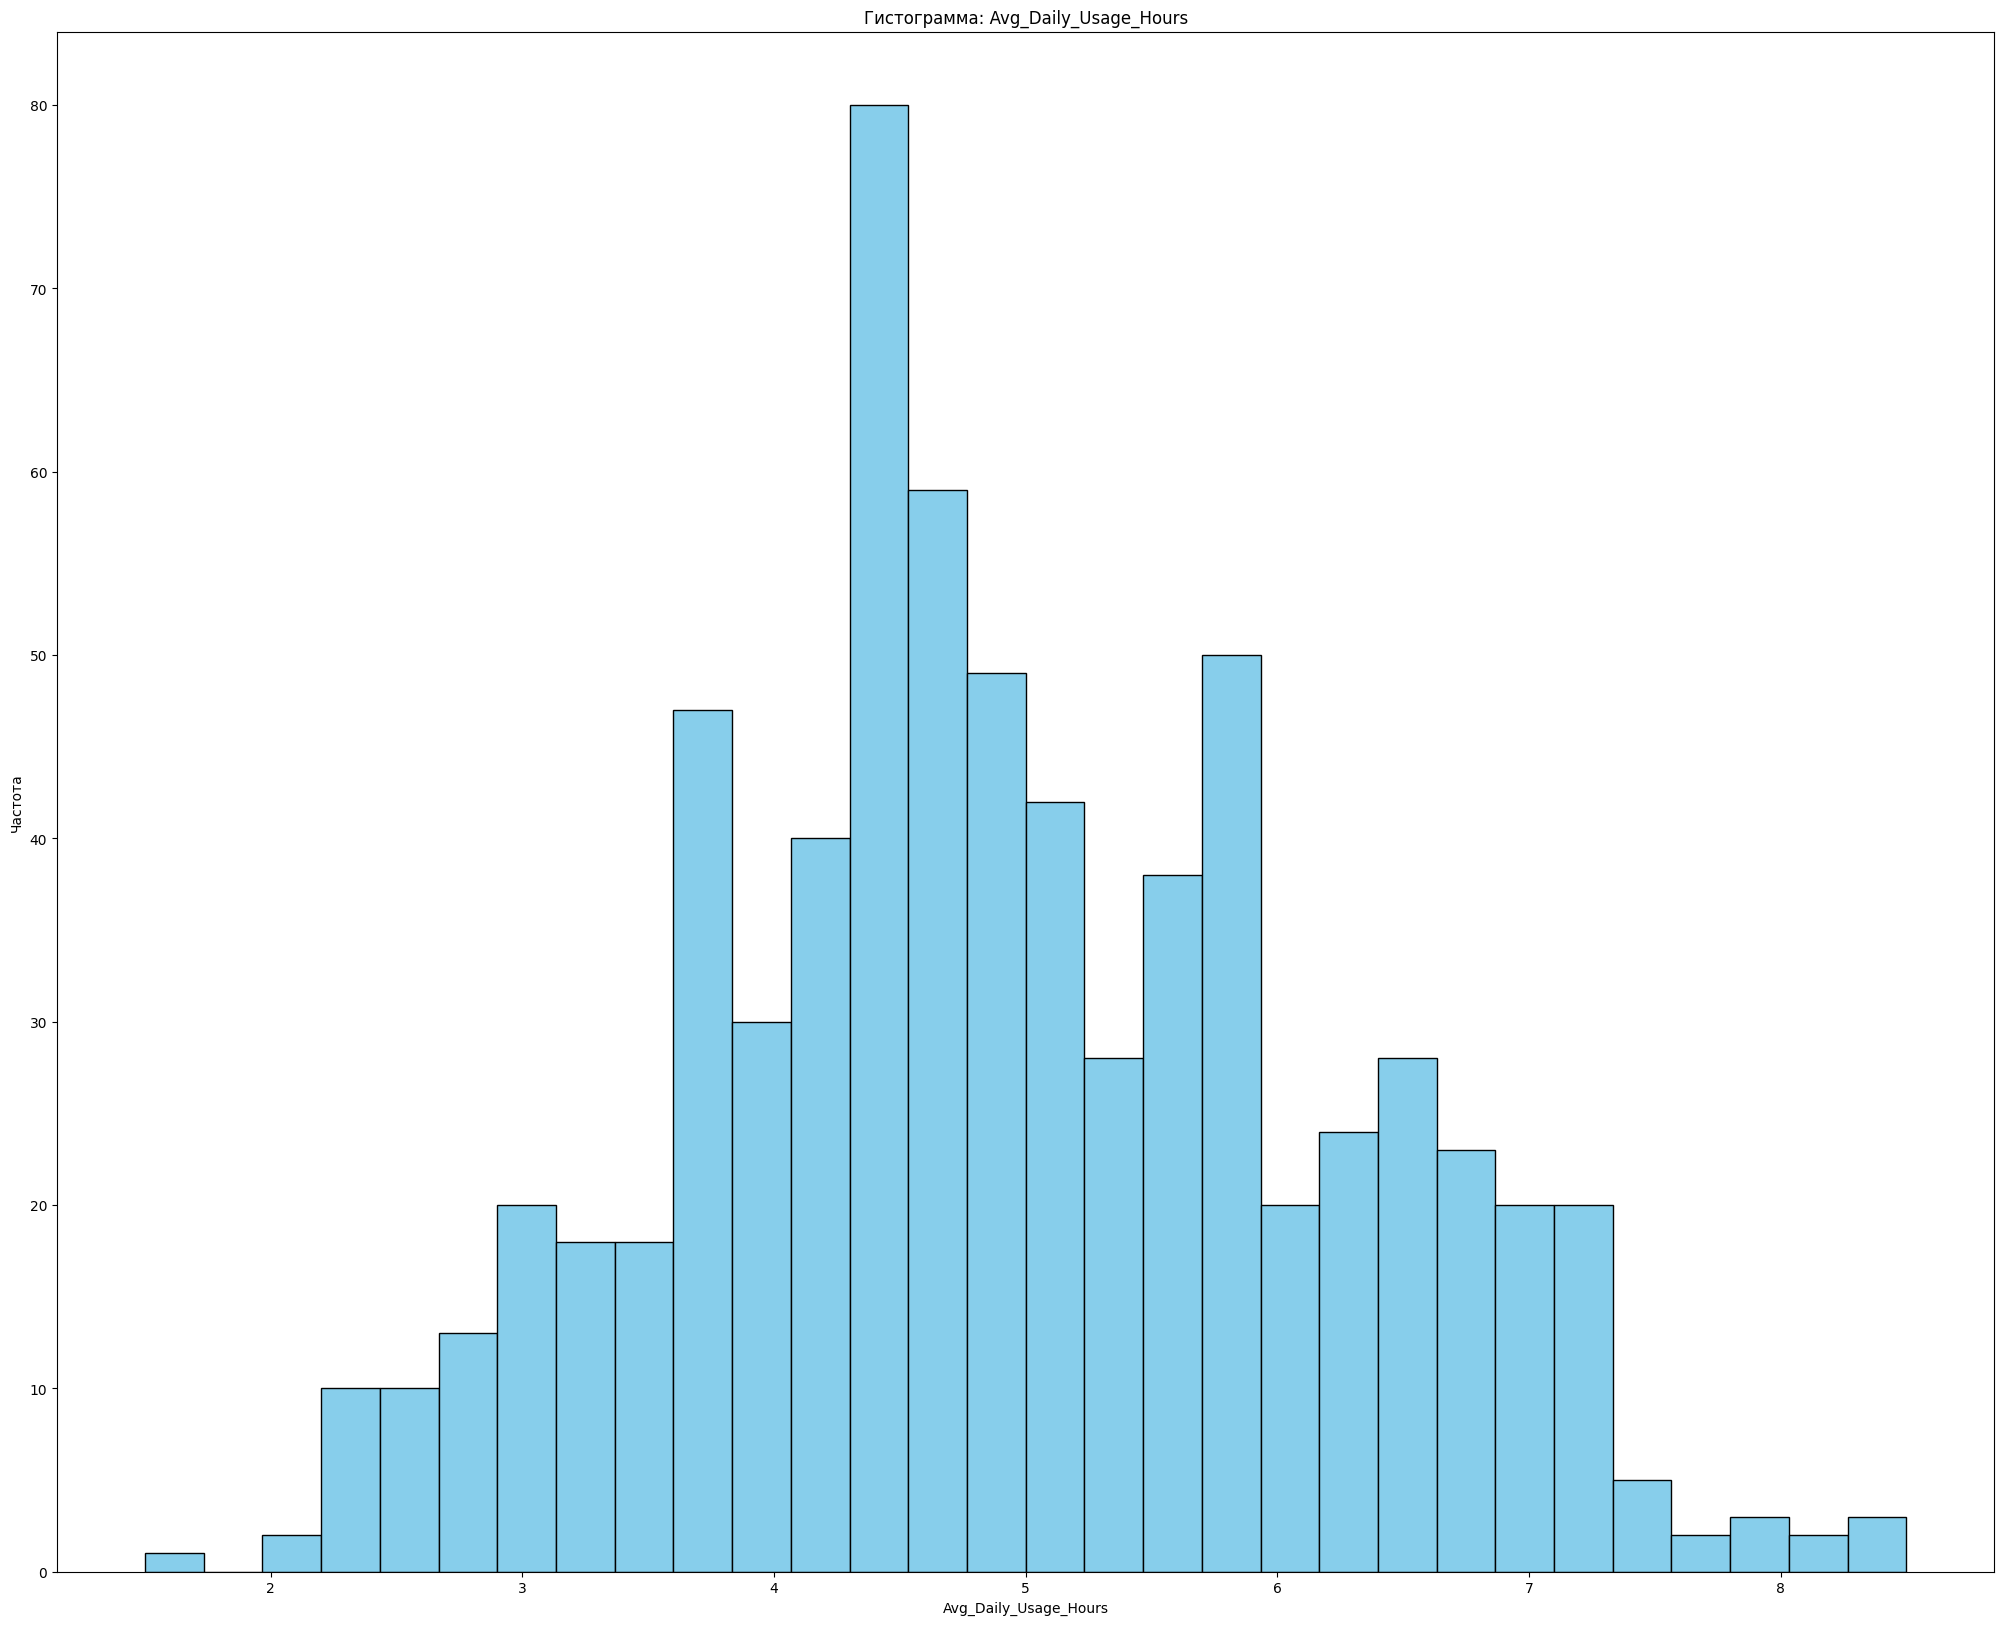

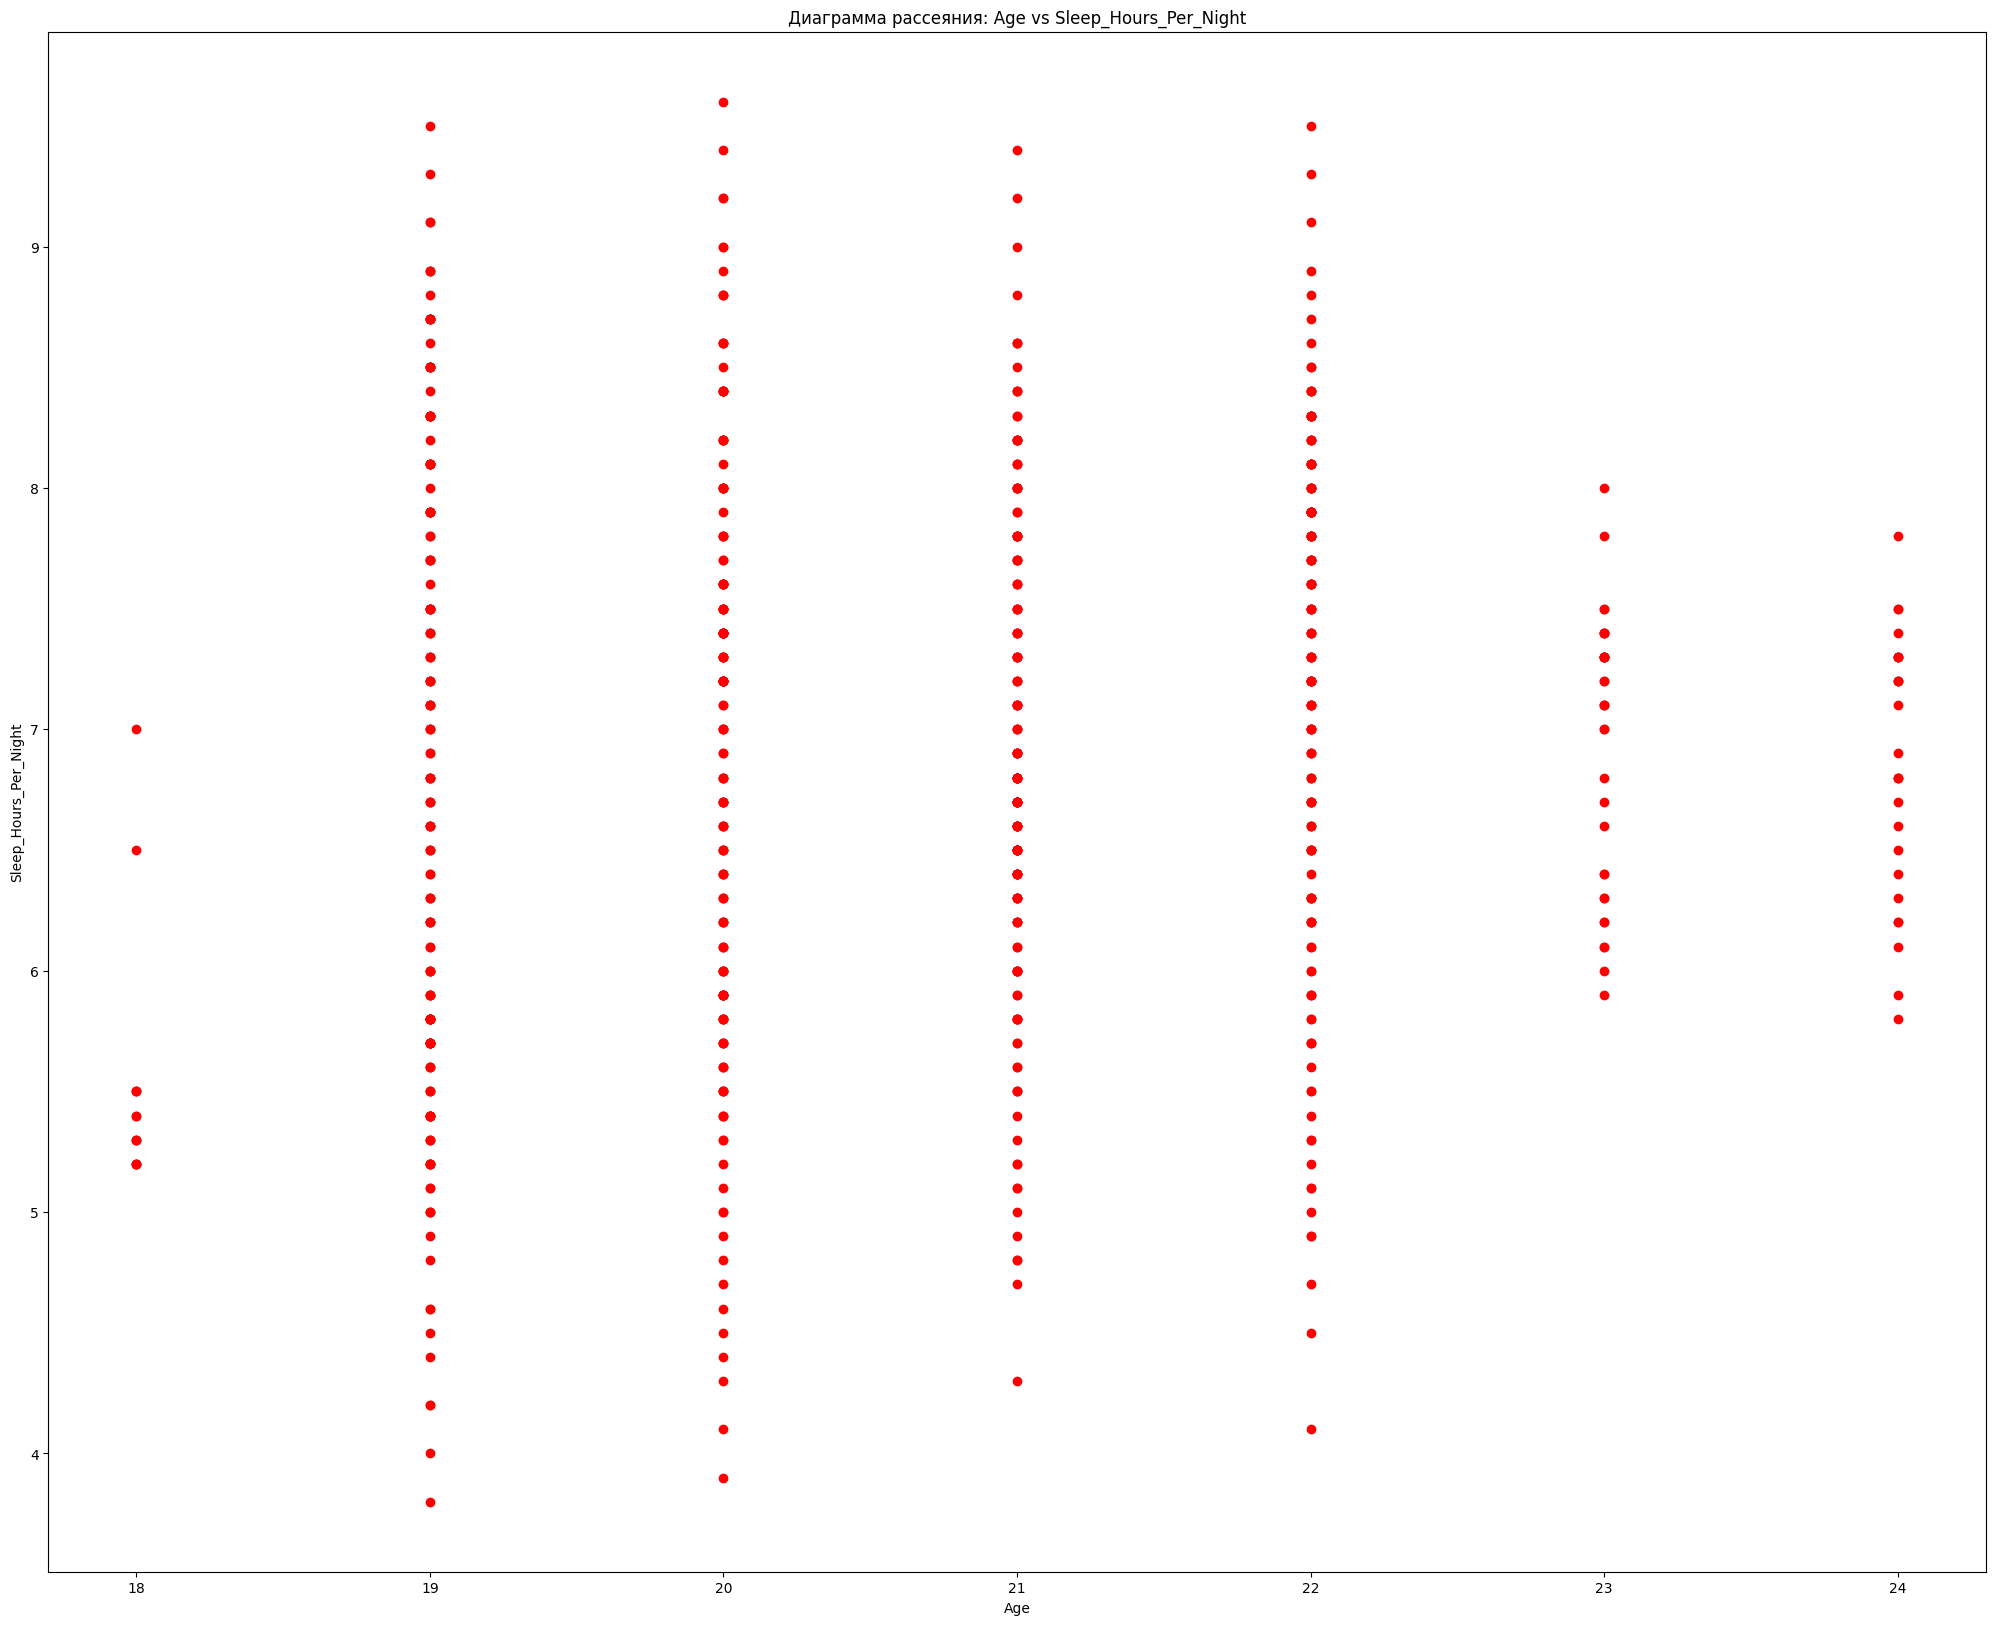

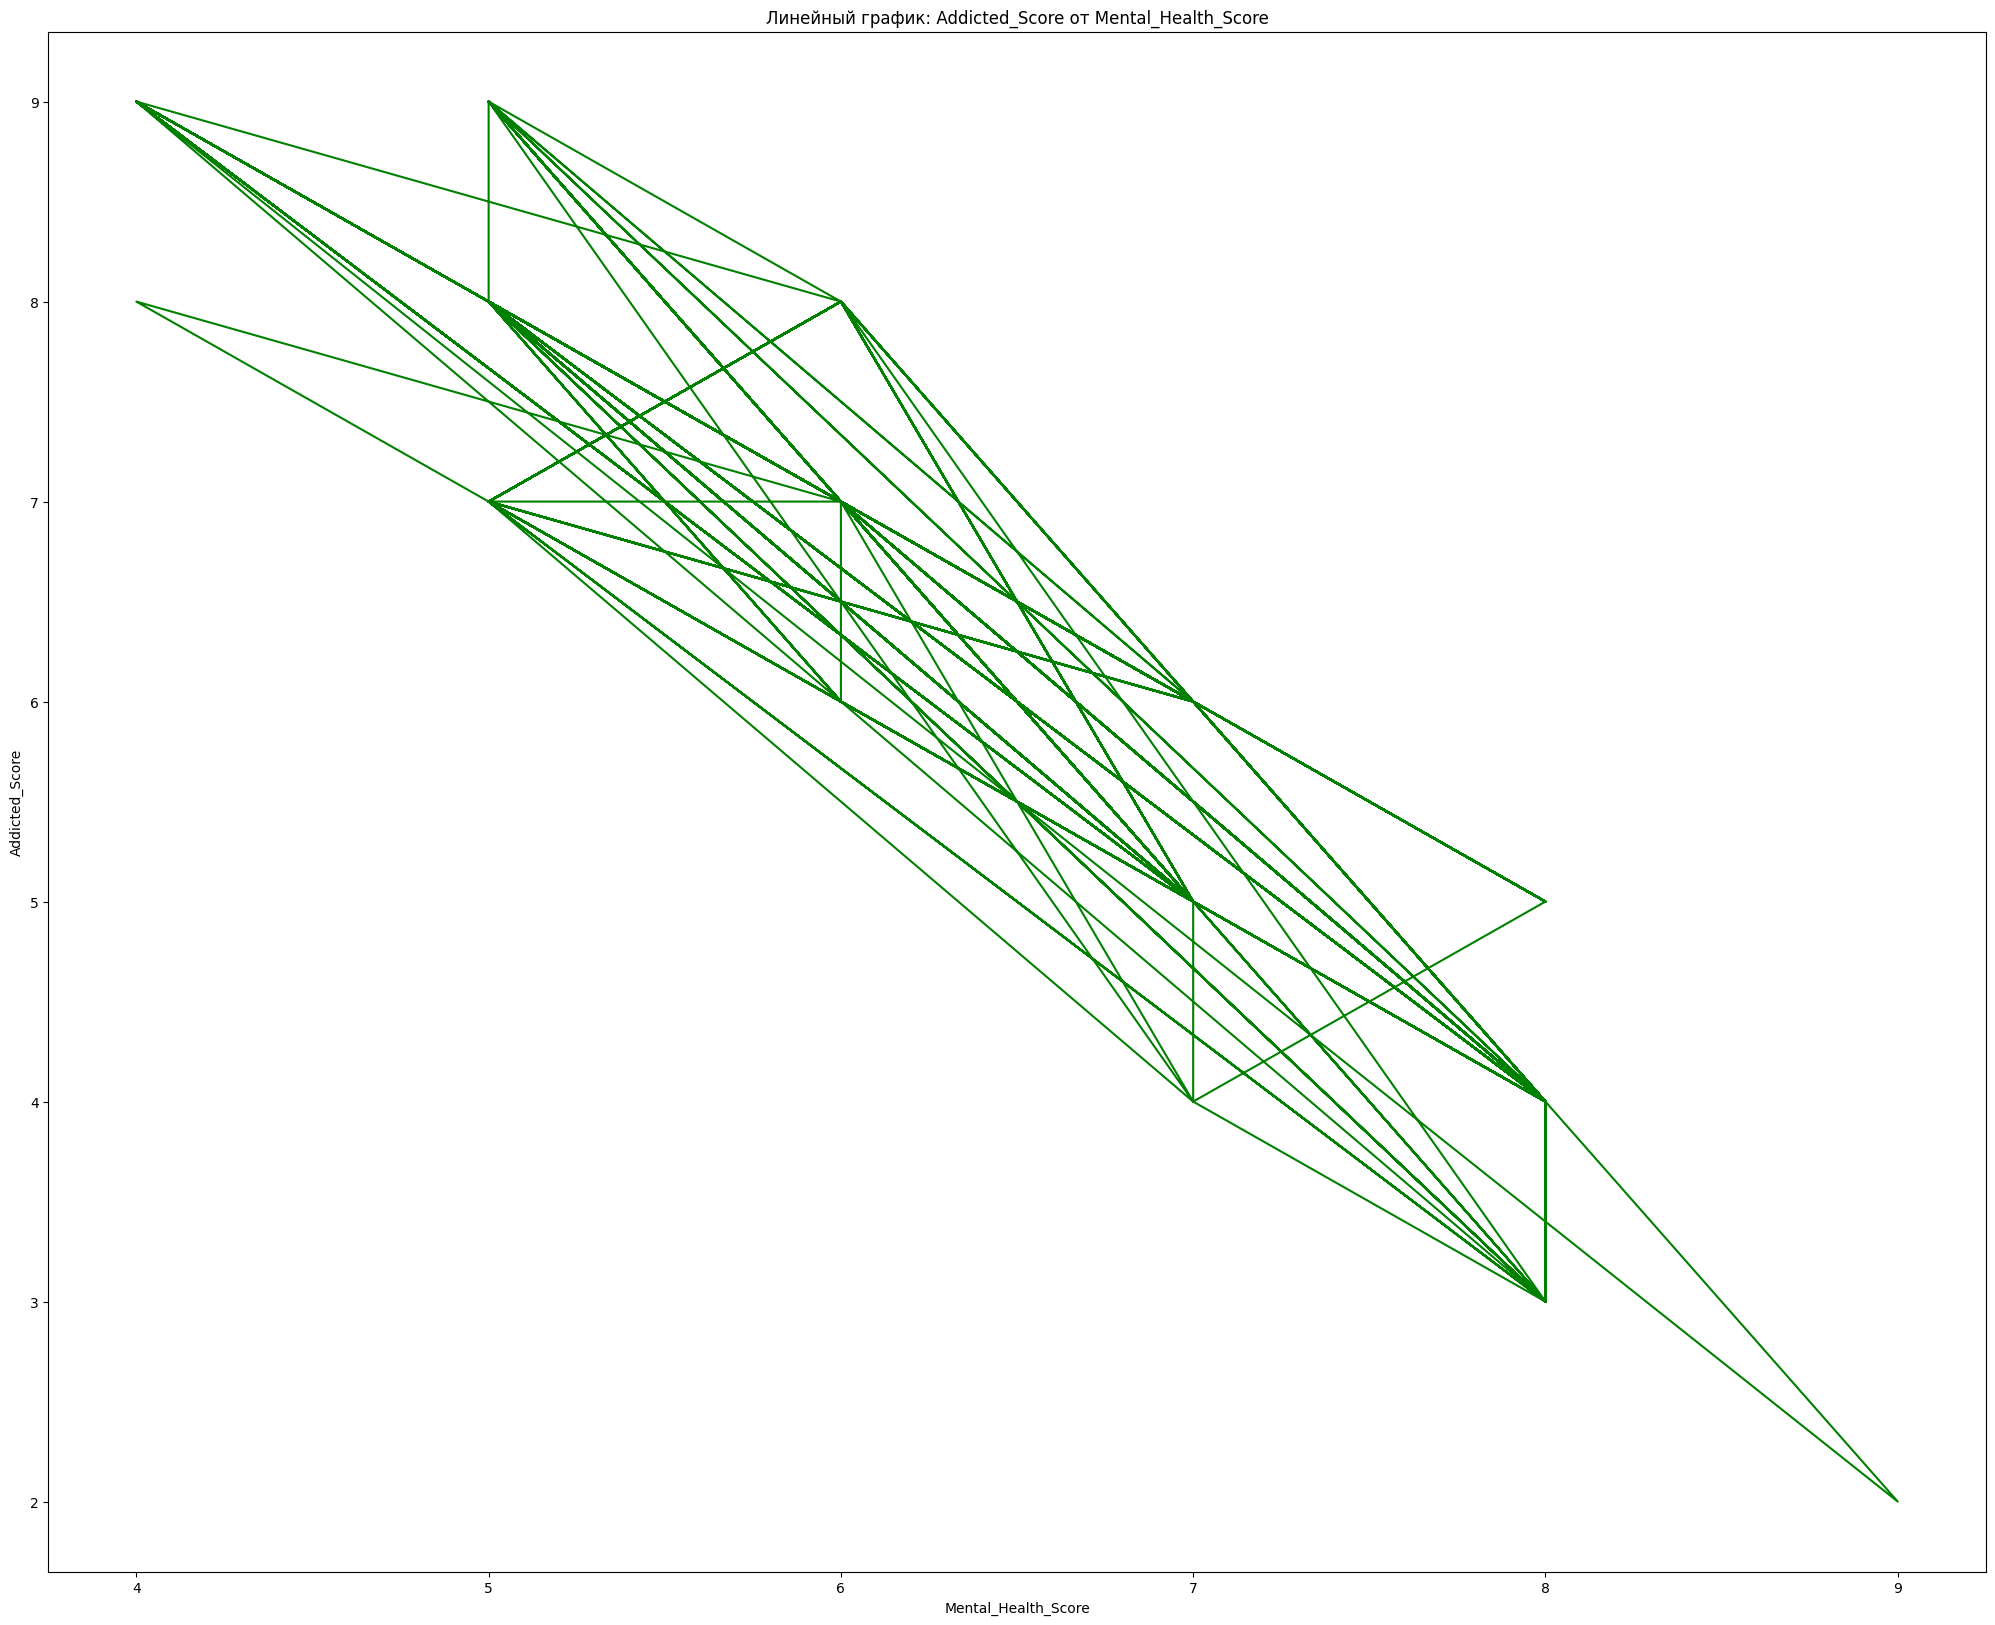

In [58]:
# Визуализация
vz = DataVisualizer(rows=1, cols=1, figsize=(25,20))
vz.add_histogram(data, column='Avg_Daily_Usage_Hours', bins=30, color='skyblue', edgecolor='black')
vz = DataVisualizer(rows=1, cols=1, figsize=(25,20))
vz.add_scatter_plot(data, x='Age', y='Sleep_Hours_Per_Night', alpha=1, color='red')
vz = DataVisualizer(rows=1, cols=1, figsize=(25,20))
vz.add_line_plot(data, x='Mental_Health_Score', y='Addicted_Score', color='green')